# Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
from keras.layers import Dropout
from tensorflow import keras
import cv2
from glob import glob

from keras.models import model_from_json

# Dataset

There are 20580 images of 120 breeds in the Stanford Dog Dataset. In this notebook, I will be working with only 10 breeds.The 10 breeds are selected so that they are different from one another. I will first build a baseline CNN model and then try to improve it by using preprocessing techniques, additional layers, batchnormalization, dropout, etc...

First we need to split the data into train, validation and test (holdout) sets. 

Creation of train, validation and test folders using 80/10/10 ratio.

In [ ]:
# rename folders to keep dog names only

# for files in os.listdir():
#   os.rename(files, files.split('-')[-1])

In [ ]:
# pip install split-folders

Split folders

In [ ]:
# import splitfolders
# splitfolders.ratio("10_breeds", output="10_breeds_split", seed=1337, ratio=(.8, .1, .1), group_prefix=None) # default values

In [ ]:
%cd 10_breeds_split/

/content/drive/My Drive/OpenClassrooms/P6_fatmi_amine/10_breeds_split


In [ ]:
%cd Images

In [ ]:
folders = [name for name in os.listdir('../Images')]

In [ ]:
len(folders)

120

Count images per breed

In [ ]:
count_images = {}
for folder in folders:
  content = os.listdir(folder)
  count_images[folder]=len(content)

In [ ]:
import operator
max(count_images.items(), key=operator.itemgetter(1)), min(count_images.items(), key=operator.itemgetter(1))

(('Maltese_dog', 252), ('redbone', 148))

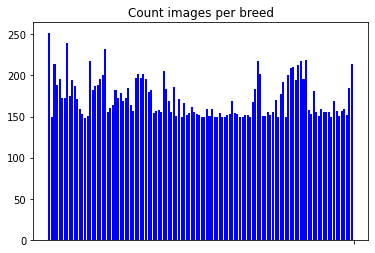

In [ ]:
plt.bar(list(count_images.keys()), count_images.values(), color='b')
plt.xticks('')
plt.title('Count images per breed')
plt.show()

We have got 120 breeds in our dataset. The number of images per breed is between 148 and 252. The dataset is rather balanced. 

# Data Augmentation

**Vertical Shift**

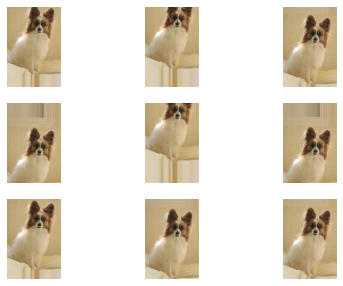

In [ ]:
# example of vertical shift image augmentation
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
# load the image
img = load_img(('/content/drive/MyDrive/OpenClassrooms/P6_fatmi_amine/10_breeds_split/train/papillon/n02086910_862.jpg'))
# convert to numpy array
data = img_to_array(img)
# expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(height_shift_range=0.3)
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
plt.figure(figsize=(7,5))
for i in range(9):
  # define subplot
  pyplot.subplot(330 + 1 + i)
  # generate batch of images
  batch = it.next()
  # convert to unsigned integers for viewing
  image = batch[0].astype('uint8')

  # plot raw pixel data
  pyplot.imshow(image)
  plt.axis('off')

**Rotation**

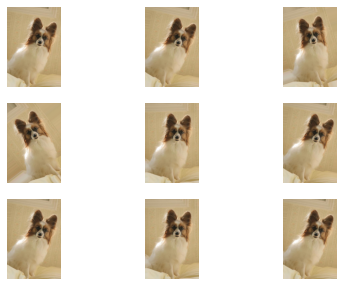

In [ ]:
# example of vertical shift image augmentation
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
# load the image
img = load_img(('/10_breeds_split/train/papillon/n02086910_862.jpg'))
# convert to numpy array
data = img_to_array(img)
# expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(rotation_range=40)
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
plt.figure(figsize=(7,5))
for i in range(9):
  # define subplot
  pyplot.subplot(330 + 1 + i)
  # generate batch of images
  batch = it.next()
  # convert to unsigned integers for viewing
  image = batch[0].astype('uint8')

  # plot raw pixel data
  pyplot.imshow(image)
  plt.axis('off')

**Zoom**

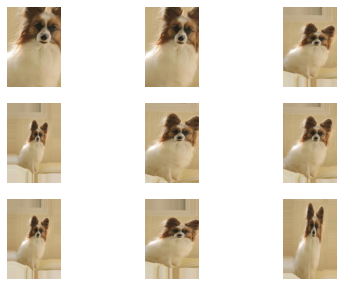

In [ ]:
# example of vertical shift image augmentation
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
# load the image
img = load_img(('/10_breeds_split/train/papillon/n02086910_862.jpg'))
# convert to numpy array
data = img_to_array(img)
# expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(zoom_range=0.5)
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
plt.figure(figsize=(7,5))
for i in range(9):
  # define subplot
  pyplot.subplot(330 + 1 + i)
  # generate batch of images
  batch = it.next()
  # convert to unsigned integers for viewing
  image = batch[0].astype('uint8')

  # plot raw pixel data
  pyplot.imshow(image)
  plt.axis('off')

In [ ]:
rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode='nearest'

**Horizontal Flip**

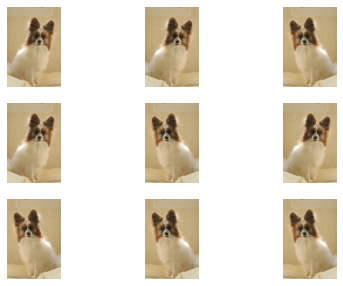

In [ ]:
# example of vertical shift image augmentation
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
# load the image
img = load_img(('/10_breeds_split/train/papillon/n02086910_862.jpg'))
# convert to numpy array
data = img_to_array(img)
# expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(horizontal_flip=True)
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
plt.figure(figsize=(7,5))
for i in range(9):
  # define subplot
  pyplot.subplot(330 + 1 + i)
  # generate batch of images
  batch = it.next()
  # convert to unsigned integers for viewing
  image = batch[0].astype('uint8')

  # plot raw pixel data
  pyplot.imshow(image)
  plt.axis('off')

In the next sections, I will first build a baseline CNN model. Then I will be testing different configurations to see how we can improve the baseline model. These includes:
* Additional Conv2D + MaxPool2D
* Droupout layers
* BatchNormalization
* DataAugmentation
* Number of neurons in dense layer

# Model baseline

## Data preprocessing

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255
                                   )
 
val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
training_set = train_datagen.flow_from_directory('train',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 1447 images belonging to 10 classes.


In [ ]:
validation_set = val_datagen.flow_from_directory('val',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 177 images belonging to 10 classes.


In [ ]:
test_set = test_datagen.flow_from_directory('test',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 190 images belonging to 10 classes.


In [ ]:
list(training_set.class_indices.keys())

['American_Staffordshire_terrier',
 'Chihuahua',
 'Ibizan_hound',
 'Saluki',
 'Scottish_deerhound',
 'basset',
 'papillon',
 'redbone',
 'toy_terrier',
 'whippet']

## CNN baseline model

In [ ]:
model = Sequential([
                    Conv2D(16, (3,3), activation='relu', input_shape=(150,150,3)),
                    MaxPool2D(2,2),
 
                    Conv2D(32, (3,3), activation='relu'),
                    MaxPool2D(2,2),
 
                    Flatten(),
                    Dense(32, activation='relu'),
                    Dense(10, activation='softmax')
])

## CNN architecture

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 41472)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                1327136   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                3

## Compile and fit CNN model

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [ ]:
model_fit = model.fit(
    training_set,
    epochs=10,
    validation_data=validation_set
)

Epoch 1/10
46/46 [==============================] - 343s 7s/step - loss: 2.4968 - accuracy: 0.1226 - val_loss: 2.3015 - val_accuracy: 0.1299
Epoch 2/10
46/46 [==============================] - 7s 148ms/step - loss: 2.2992 - accuracy: 0.1494 - val_loss: 2.2931 - val_accuracy: 0.1186
Epoch 3/10
46/46 [==============================] - 7s 146ms/step - loss: 2.2350 - accuracy: 0.1772 - val_loss: 2.6709 - val_accuracy: 0.1356
Epoch 4/10
46/46 [==============================] - 7s 147ms/step - loss: 2.0269 - accuracy: 0.3354 - val_loss: 2.2519 - val_accuracy: 0.2938
Epoch 5/10
46/46 [==============================] - 7s 146ms/step - loss: 1.6663 - accuracy: 0.4715 - val_loss: 2.2107 - val_accuracy: 0.2825
Epoch 6/10
46/46 [==============================] - 7s 145ms/step - loss: 1.2724 - accuracy: 0.6301 - val_loss: 2.6271 - val_accuracy: 0.2938
Epoch 7/10
46/46 [==============================] - 7s 145ms/step - loss: 0.9441 - accuracy: 0.7112 - val_loss: 2.7480 - val_accuracy: 0.2429
Epoch 8

## Accuracy and Loss

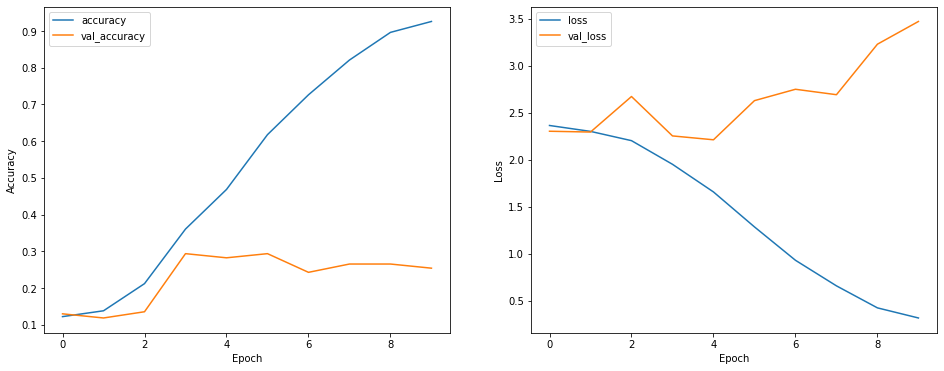

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

ax[0].plot(model_fit.history['accuracy'], label='accuracy')
ax[0].plot(model_fit.history['val_accuracy'], label='val_accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].plot(model_fit.history['loss'], label='loss')
ax[1].plot(model_fit.history['val_loss'], label='val_loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()

 ## Evaluate model on holdout set (test_set)

In [ ]:
model.evaluate(test_set)

6/6 [==============================] - 38s 8s/step - loss: 3.1671 - accuracy: 0.2316


[3.167069911956787, 0.23157894611358643]

# Model 2

On top of baseline model:

*   Add dropout(0.5)





**Data preprocessing**

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   )

val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
training_set = train_datagen.flow_from_directory('train',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 1447 images belonging to 10 classes.


In [ ]:
validation_set = val_datagen.flow_from_directory('val',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 177 images belonging to 10 classes.


In [ ]:
training_set.class_indices

{'American_Staffordshire_terrier': 0,
 'Chihuahua': 1,
 'Ibizan_hound': 2,
 'Saluki': 3,
 'Scottish_deerhound': 4,
 'basset': 5,
 'papillon': 6,
 'redbone': 7,
 'toy_terrier': 8,
 'whippet': 9}

**CNN**

In [ ]:
model = Sequential([
                    Conv2D(16, (3,3), activation='relu', input_shape=(150,150,3)),
                    MaxPool2D(2,2),

                    Conv2D(32, (3,3), activation='relu'),
                    MaxPool2D(2,2),

                    Dropout(0.5),

                    Flatten(),
                    Dense(32, activation='relu'),
                    Dense(10, activation='softmax')
])

**CNN architecture**

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 36, 36, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 41472)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)               

**Compile and fit CNN model**

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [ ]:
model_fit = model.fit(
    training_set,
    epochs=10,
    validation_data=validation_set
)

Epoch 1/10
46/46 [==============================] - 7s 152ms/step - loss: 2.8116 - accuracy: 0.1099 - val_loss: 2.2962 - val_accuracy: 0.1073
Epoch 2/10
46/46 [==============================] - 7s 147ms/step - loss: 2.2709 - accuracy: 0.1598 - val_loss: 2.2509 - val_accuracy: 0.1977
Epoch 3/10
46/46 [==============================] - 7s 146ms/step - loss: 2.1744 - accuracy: 0.2222 - val_loss: 2.2197 - val_accuracy: 0.2429
Epoch 4/10
46/46 [==============================] - 7s 151ms/step - loss: 2.0514 - accuracy: 0.2869 - val_loss: 2.2059 - val_accuracy: 0.2316
Epoch 5/10
46/46 [==============================] - 7s 151ms/step - loss: 1.8188 - accuracy: 0.4099 - val_loss: 2.3535 - val_accuracy: 0.1469
Epoch 6/10
46/46 [==============================] - 7s 148ms/step - loss: 1.5896 - accuracy: 0.4935 - val_loss: 2.2936 - val_accuracy: 0.2599
Epoch 7/10
46/46 [==============================] - 7s 148ms/step - loss: 1.3588 - accuracy: 0.5508 - val_loss: 2.4606 - val_accuracy: 0.2655
Epoch 

Accuracy vs Epochs

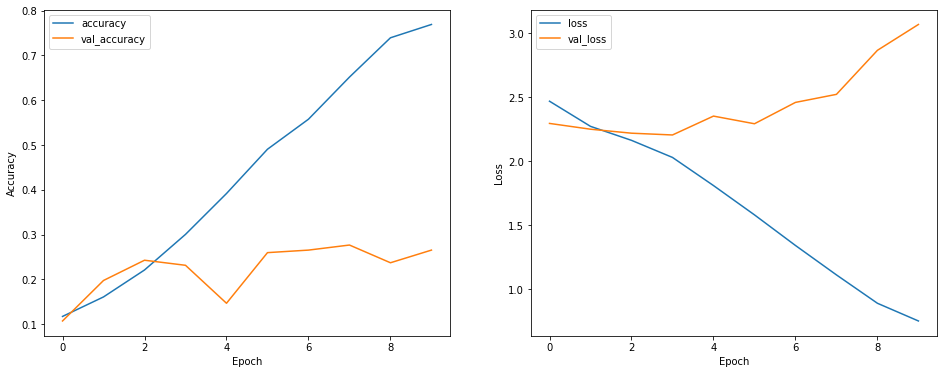

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

ax[0].plot(model_fit.history['accuracy'], label='accuracy')
ax[0].plot(model_fit.history['val_accuracy'], label='val_accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].plot(model_fit.history['loss'], label='loss')
ax[1].plot(model_fit.history['val_loss'], label='val_loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()

Evaluate test set

In [ ]:
test_set = test_datagen.flow_from_directory('test',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 190 images belonging to 10 classes.


In [ ]:
model.evaluate(test_set)

6/6 [==============================] - 1s 133ms/step - loss: 2.9882 - accuracy: 0.2526


[2.988187074661255, 0.2526315748691559]

# Model 3

On top of baseline model:


*   Add dropout(0.5)
*   Data augmentation (shear, zoom, horizontal)







Data preprocessing

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True
                                   )

val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
training_set = train_datagen.flow_from_directory('train',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 1447 images belonging to 10 classes.


In [ ]:
validation_set = val_datagen.flow_from_directory('val',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 177 images belonging to 10 classes.


In [ ]:
training_set.class_indices

{'American_Staffordshire_terrier': 0,
 'Chihuahua': 1,
 'Ibizan_hound': 2,
 'Saluki': 3,
 'Scottish_deerhound': 4,
 'basset': 5,
 'papillon': 6,
 'redbone': 7,
 'toy_terrier': 8,
 'whippet': 9}

CNN

In [ ]:
model = Sequential([
                    Conv2D(16, (3,3), activation='relu', input_shape=(150,150,3)),
                    MaxPool2D(2,2),

                    Conv2D(32, (3,3), activation='relu'),
                    MaxPool2D(2,2),

                    Dropout(0.5),

                    Flatten(),
                    Dense(128, activation='relu'),
                    Dense(10, activation='softmax')


])

CNN architecture

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 36, 36, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 41472)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)              

Compile and fit CNN model

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [ ]:
model_fit = model.fit(
    training_set,
    epochs=10,
    validation_data=validation_set
)

Epoch 1/10
46/46 [==============================] - 13s 283ms/step - loss: 3.6974 - accuracy: 0.1301 - val_loss: 2.1993 - val_accuracy: 0.1921
Epoch 2/10
46/46 [==============================] - 13s 275ms/step - loss: 2.1810 - accuracy: 0.2321 - val_loss: 2.1468 - val_accuracy: 0.2260
Epoch 3/10
46/46 [==============================] - 13s 274ms/step - loss: 2.0577 - accuracy: 0.2689 - val_loss: 2.1267 - val_accuracy: 0.2825
Epoch 4/10
46/46 [==============================] - 13s 273ms/step - loss: 1.9434 - accuracy: 0.3238 - val_loss: 2.1720 - val_accuracy: 0.2655
Epoch 5/10
46/46 [==============================] - 13s 278ms/step - loss: 1.8469 - accuracy: 0.3445 - val_loss: 1.9496 - val_accuracy: 0.3446
Epoch 6/10
46/46 [==============================] - 13s 282ms/step - loss: 1.7530 - accuracy: 0.3943 - val_loss: 2.0106 - val_accuracy: 0.3446
Epoch 7/10
46/46 [==============================] - 13s 274ms/step - loss: 1.6699 - accuracy: 0.4257 - val_loss: 2.0195 - val_accuracy: 0.3503

Accuracy vs Epochs

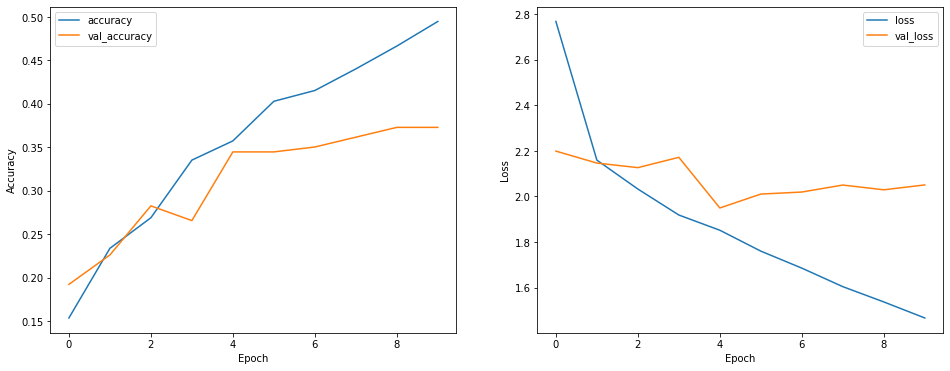

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

ax[0].plot(model_fit.history['accuracy'], label='accuracy')
ax[0].plot(model_fit.history['val_accuracy'], label='val_accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].plot(model_fit.history['loss'], label='loss')
ax[1].plot(model_fit.history['val_loss'], label='val_loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()

Evaluate test set

In [ ]:
test_set = test_datagen.flow_from_directory('test',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 190 images belonging to 10 classes.


In [ ]:
model.evaluate(test_set)

6/6 [==============================] - 1s 128ms/step - loss: 1.9836 - accuracy: 0.3789


[1.9836032390594482, 0.378947377204895]

# Model 4




*   Add dropout(0.5)
*   Data augmentation (shear, zoom, horizontal)
*   Increase epochs from 10 to 20







Data preprocessing

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True
                                   )

val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
training_set = train_datagen.flow_from_directory('train',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 1447 images belonging to 10 classes.


In [ ]:
validation_set = val_datagen.flow_from_directory('val',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 177 images belonging to 10 classes.


In [ ]:
training_set.class_indices

{'American_Staffordshire_terrier': 0,
 'Chihuahua': 1,
 'Ibizan_hound': 2,
 'Saluki': 3,
 'Scottish_deerhound': 4,
 'basset': 5,
 'papillon': 6,
 'redbone': 7,
 'toy_terrier': 8,
 'whippet': 9}

CNN

In [ ]:
model = Sequential([
                    Conv2D(16, (3,3), activation='relu', input_shape=(150,150,3)),
                    MaxPool2D(2,2),

                    Conv2D(32, (3,3), activation='relu'),
                    MaxPool2D(2,2),

                    Dropout(0.5),

                    Flatten(),
                    Dense(128, activation='relu'),
                    Dense(10, activation='softmax')


])

CNN architecture

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 36, 36, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 41472)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)              

Compile and fit CNN model

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [ ]:
model_fit = model.fit(
    training_set,
    epochs=20,
    validation_data=validation_set
)

Epoch 1/20
46/46 [==============================] - 13s 281ms/step - loss: 3.3933 - accuracy: 0.1133 - val_loss: 2.2375 - val_accuracy: 0.1638
Epoch 2/20
46/46 [==============================] - 13s 275ms/step - loss: 2.2640 - accuracy: 0.1741 - val_loss: 2.2132 - val_accuracy: 0.2316
Epoch 3/20
46/46 [==============================] - 13s 274ms/step - loss: 2.1864 - accuracy: 0.2178 - val_loss: 2.0755 - val_accuracy: 0.3333
Epoch 4/20
46/46 [==============================] - 13s 276ms/step - loss: 2.0658 - accuracy: 0.2808 - val_loss: 2.0966 - val_accuracy: 0.2429
Epoch 5/20
46/46 [==============================] - 13s 275ms/step - loss: 1.9550 - accuracy: 0.3371 - val_loss: 1.9816 - val_accuracy: 0.2994
Epoch 6/20
46/46 [==============================] - 13s 282ms/step - loss: 1.8461 - accuracy: 0.3534 - val_loss: 1.9874 - val_accuracy: 0.2938
Epoch 7/20
46/46 [==============================] - 13s 275ms/step - loss: 1.7714 - accuracy: 0.4052 - val_loss: 1.9511 - val_accuracy: 0.3107

Accuracy vs Epochs

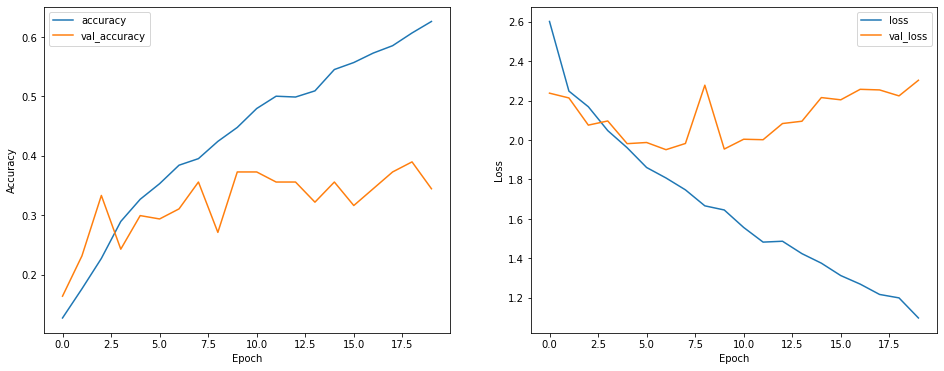

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

ax[0].plot(model_fit.history['accuracy'], label='accuracy')
ax[0].plot(model_fit.history['val_accuracy'], label='val_accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].plot(model_fit.history['loss'], label='loss')
ax[1].plot(model_fit.history['val_loss'], label='val_loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()

Evaluate test set

In [ ]:
test_set = test_datagen.flow_from_directory('test',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 190 images belonging to 10 classes.


In [ ]:
model.evaluate(test_set)

6/6 [==============================] - 1s 133ms/step - loss: 2.2289 - accuracy: 0.3632


[2.228914260864258, 0.36315789818763733]

# Model 5




*   Add dropout(0.5)
*   Data augmentation (shear, zoom, horizontal)
*   Increase epochs from 10 to 50
*   Add Conv2D + MaxPool2D
*   Élément de liste









Data preprocessing

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True
                                   )

val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
training_set = train_datagen.flow_from_directory('train',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 1447 images belonging to 10 classes.


In [ ]:
validation_set = val_datagen.flow_from_directory('val',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 177 images belonging to 10 classes.


In [ ]:
training_set.class_indices

{'American_Staffordshire_terrier': 0,
 'Chihuahua': 1,
 'Ibizan_hound': 2,
 'Saluki': 3,
 'Scottish_deerhound': 4,
 'basset': 5,
 'papillon': 6,
 'redbone': 7,
 'toy_terrier': 8,
 'whippet': 9}

CNN

In [ ]:
model = Sequential([
                    Conv2D(16, (3,3), activation='relu', input_shape=(150,150,3)),
                    MaxPool2D(2,2),

                    Conv2D(32, (3,3), activation='relu'),
                    MaxPool2D(2,2),

                    Conv2D(64, (3,3), activation='relu'),
                    MaxPool2D(2,2),

                    Dropout(0.5),

                    Flatten(),
                    Dense(128, activation='relu'),
                    Dense(10, activation='softmax')


])

CNN architecture

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 17, 17, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 17, 17, 64)       

Compile and fit CNN model

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [ ]:
model_fit = model.fit(
    training_set,
    epochs=50,
    validation_data=validation_set
)

Epoch 1/50
46/46 [==============================] - 14s 284ms/step - loss: 2.7245 - accuracy: 0.1425 - val_loss: 2.1897 - val_accuracy: 0.2429
Epoch 2/50
46/46 [==============================] - 13s 283ms/step - loss: 2.1826 - accuracy: 0.2327 - val_loss: 2.0809 - val_accuracy: 0.2655
Epoch 3/50
46/46 [==============================] - 13s 282ms/step - loss: 2.0651 - accuracy: 0.2783 - val_loss: 2.0290 - val_accuracy: 0.2881
Epoch 4/50
46/46 [==============================] - 13s 284ms/step - loss: 1.9614 - accuracy: 0.3225 - val_loss: 2.0823 - val_accuracy: 0.3107
Epoch 5/50
46/46 [==============================] - 13s 287ms/step - loss: 1.8358 - accuracy: 0.3814 - val_loss: 2.0167 - val_accuracy: 0.2938
Epoch 6/50
46/46 [==============================] - 13s 282ms/step - loss: 1.7977 - accuracy: 0.3767 - val_loss: 2.0702 - val_accuracy: 0.3277
Epoch 7/50
46/46 [==============================] - 13s 281ms/step - loss: 1.7416 - accuracy: 0.4159 - val_loss: 2.0767 - val_accuracy: 0.3220

Accuracy vs Epochs

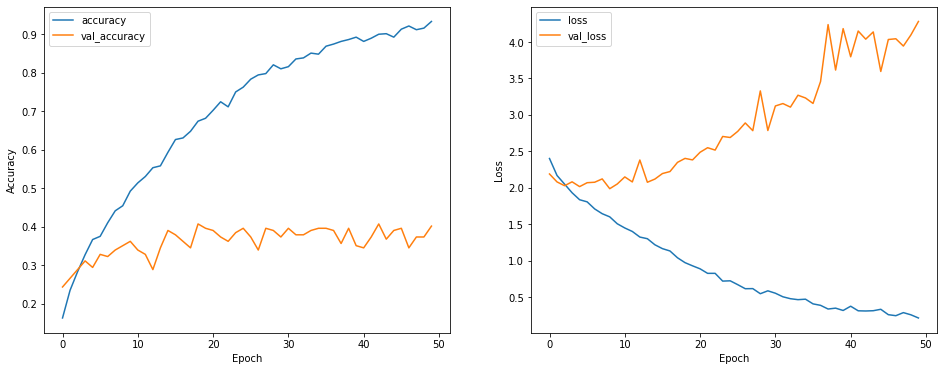

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

ax[0].plot(model_fit.history['accuracy'], label='accuracy')
ax[0].plot(model_fit.history['val_accuracy'], label='val_accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].plot(model_fit.history['loss'], label='loss')
ax[1].plot(model_fit.history['val_loss'], label='val_loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()

Evaluate test set

In [ ]:
test_set = test_datagen.flow_from_directory('test',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 190 images belonging to 10 classes.


In [ ]:
model.evaluate(test_set)

6/6 [==============================] - 1s 132ms/step - loss: 4.0085 - accuracy: 0.3684


[4.00853967666626, 0.3684210479259491]

# Model 6




*   Add dropout(0.5)
*   Data augmentation (shear, zoom, horizontal)
*   Increase epochs from 10 to 30
*   Add Conv2D + MaxPool2D
*   Add dropout(0.5) after the 2nd conv layer
*   Reduce batch_size to 16 (32 before)
*   Élément de liste











Data preprocessing

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True
                                   )

val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
training_set = train_datagen.flow_from_directory('train',
                                                 target_size = (150, 150),
                                                 batch_size = 16,
                                                 class_mode = 'categorical')

Found 1447 images belonging to 10 classes.


In [ ]:
validation_set = val_datagen.flow_from_directory('val',
                                                 target_size = (150, 150),
                                                 batch_size = 16,
                                                 class_mode = 'categorical')

Found 177 images belonging to 10 classes.


In [ ]:
training_set.class_indices

{'American_Staffordshire_terrier': 0,
 'Chihuahua': 1,
 'Ibizan_hound': 2,
 'Saluki': 3,
 'Scottish_deerhound': 4,
 'basset': 5,
 'papillon': 6,
 'redbone': 7,
 'toy_terrier': 8,
 'whippet': 9}

CNN

In [ ]:
model = Sequential([
                    Conv2D(16, (3,3), activation='relu', input_shape=(150,150,3)),
                    MaxPool2D(2,2),

                    Conv2D(32, (3,3), activation='relu'),
                    MaxPool2D(2,2),

                    Dropout(0.5),

                    Conv2D(64, (3,3), activation='relu'),
                    MaxPool2D(2,2),

                    Dropout(0.5),

                    Flatten(),
                    Dense(128, activation='relu'),
                    Dense(10, activation='softmax')


])

CNN architecture

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 17, 17, 64)       

Compile and fit CNN model

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [ ]:
model_fit = model.fit(
    training_set,
    # steps_per_epoch=3,
    epochs=30,
    validation_data=validation_set
)

Epoch 1/30
91/91 [==============================] - 14s 145ms/step - loss: 2.5818 - accuracy: 0.1308 - val_loss: 2.2747 - val_accuracy: 0.2542
Epoch 2/30
91/91 [==============================] - 13s 141ms/step - loss: 2.2171 - accuracy: 0.2148 - val_loss: 2.1537 - val_accuracy: 0.2373
Epoch 3/30
91/91 [==============================] - 13s 141ms/step - loss: 2.1171 - accuracy: 0.2574 - val_loss: 2.0550 - val_accuracy: 0.3107
Epoch 4/30
91/91 [==============================] - 13s 142ms/step - loss: 2.0167 - accuracy: 0.2788 - val_loss: 2.0834 - val_accuracy: 0.2712
Epoch 5/30
91/91 [==============================] - 13s 143ms/step - loss: 1.9818 - accuracy: 0.2863 - val_loss: 1.9790 - val_accuracy: 0.2938
Epoch 6/30
91/91 [==============================] - 13s 146ms/step - loss: 1.8812 - accuracy: 0.3563 - val_loss: 1.9422 - val_accuracy: 0.3333
Epoch 7/30
91/91 [==============================] - 13s 144ms/step - loss: 1.8294 - accuracy: 0.3759 - val_loss: 1.9276 - val_accuracy: 0.3164

Accuracy vs Epochs

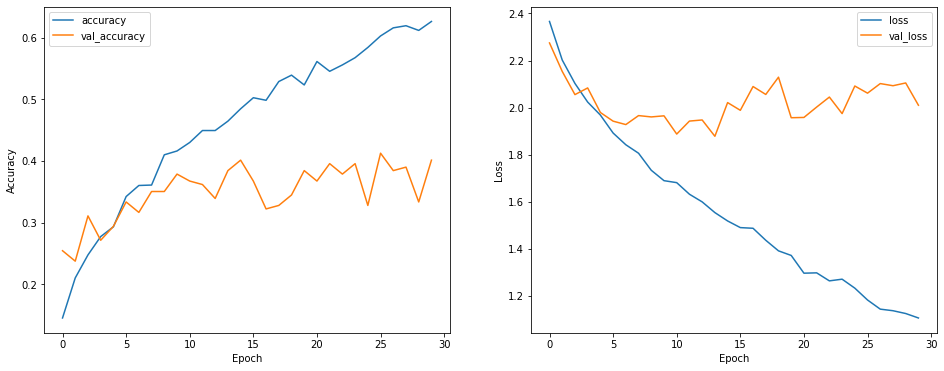

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

ax[0].plot(model_fit.history['accuracy'], label='accuracy')
ax[0].plot(model_fit.history['val_accuracy'], label='val_accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].plot(model_fit.history['loss'], label='loss')
ax[1].plot(model_fit.history['val_loss'], label='val_loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()

Evaluate test set

In [ ]:
test_set = test_datagen.flow_from_directory('test',
                                                 target_size = (150, 150),
                                                 batch_size = 16,
                                                 class_mode = 'categorical')

Found 190 images belonging to 10 classes.


In [ ]:
model.evaluate(test_set)

12/12 [==============================] - 1s 74ms/step - loss: 1.9608 - accuracy: 0.3579


[1.9608228206634521, 0.35789474844932556]

# Model 7




*   Add dropout(0.5)
*   Data augmentation (shear, zoom, horizontal,...)
*   Increase epochs from 10 to 100
*   Add callback
*   Add layer










Data preprocessing

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode='nearest'
                                   )

val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
training_set = train_datagen.flow_from_directory('train',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 1447 images belonging to 10 classes.


In [ ]:
validation_set = val_datagen.flow_from_directory('val',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 177 images belonging to 10 classes.


In [ ]:
training_set.class_indices

{'American_Staffordshire_terrier': 0,
 'Chihuahua': 1,
 'Ibizan_hound': 2,
 'Saluki': 3,
 'Scottish_deerhound': 4,
 'basset': 5,
 'papillon': 6,
 'redbone': 7,
 'toy_terrier': 8,
 'whippet': 9}

CNN

In [ ]:
model = Sequential([
                    Conv2D(16, (3,3), activation='relu', input_shape=(150,150,3)),
                    MaxPool2D(2,2),

                    Conv2D(32, (3,3), activation='relu'),
                    MaxPool2D(2,2),

                    Conv2D(32, (3,3), activation='relu'),
                    MaxPool2D(2,2),

                    Dropout(0.5),

                    Flatten(),
                    Dense(128, activation='relu'),
                    Dense(10, activation='softmax')


])

CNN architecture

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 34, 34, 32)        9248      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 17, 17, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 17, 17, 32)       

Compile and fit CNN model

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [ ]:
from keras import callbacks 
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                        mode ="min", patience = 8,  
                                        restore_best_weights = True)

model_fit = model.fit(
    training_set,
    # steps_per_epoch=3,
    epochs=100,
    validation_data=validation_set,
    callbacks=[earlystopping]
)

Epoch 1/100
46/46 [==============================] - 14s 284ms/step - loss: 2.5542 - accuracy: 0.1081 - val_loss: 2.2717 - val_accuracy: 0.1469
Epoch 2/100
46/46 [==============================] - 13s 274ms/step - loss: 2.2933 - accuracy: 0.1375 - val_loss: 2.1688 - val_accuracy: 0.2542
Epoch 3/100
46/46 [==============================] - 13s 278ms/step - loss: 2.2114 - accuracy: 0.2144 - val_loss: 2.1241 - val_accuracy: 0.2599
Epoch 4/100
46/46 [==============================] - 13s 278ms/step - loss: 2.1683 - accuracy: 0.2120 - val_loss: 2.1935 - val_accuracy: 0.1864
Epoch 5/100
46/46 [==============================] - 13s 275ms/step - loss: 2.1346 - accuracy: 0.2405 - val_loss: 2.0290 - val_accuracy: 0.2881
Epoch 6/100
46/46 [==============================] - 13s 277ms/step - loss: 2.1109 - accuracy: 0.2452 - val_loss: 1.9931 - val_accuracy: 0.2825
Epoch 7/100
46/46 [==============================] - 13s 275ms/step - loss: 2.0969 - accuracy: 0.2200 - val_loss: 2.0064 - val_accuracy:

Accuracy vs Epochs

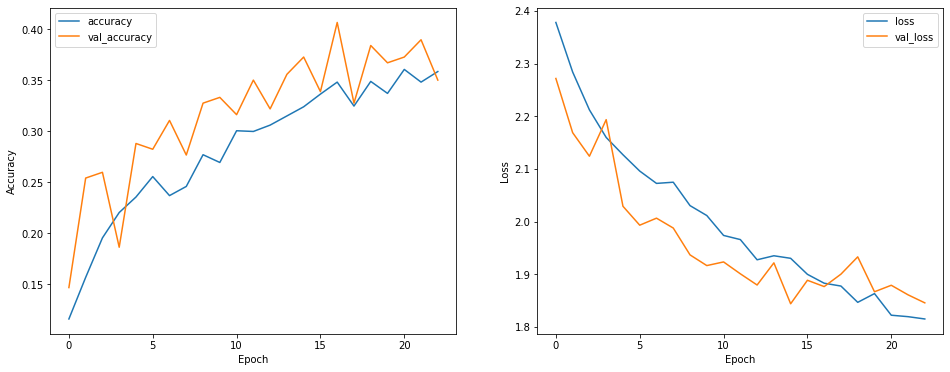

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

ax[0].plot(model_fit.history['accuracy'], label='accuracy')
ax[0].plot(model_fit.history['val_accuracy'], label='val_accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].plot(model_fit.history['loss'], label='loss')
ax[1].plot(model_fit.history['val_loss'], label='val_loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()

Evaluate test set

In [ ]:
test_set = test_datagen.flow_from_directory('test',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 190 images belonging to 10 classes.


In [ ]:
model.evaluate(test_set)

6/6 [==============================] - 1s 125ms/step - loss: 1.8731 - accuracy: 0.3737


[1.87307870388031, 0.37368419766426086]

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
!pwd

/content/drive/My Drive/OpenClassrooms/P6_fatmi_amine/10_breeds_split


In [ ]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_set = test_datagen.flow_from_directory('test',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',
                                            shuffle=False)

Found 190 images belonging to 10 classes.


In [ ]:
loaded_model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [ ]:
prediction = loaded_model.evaluate(test_set)

6/6 [==============================] - 1s 131ms/step - loss: 1.8731 - accuracy: 0.3737


# Model 8




*   Add dropout(0.5)
*   Data augmentation (shear, zoom, horizontal,...)
*   Increase epochs from 10 to 100
*   Add callback
*   Add layer










Data preprocessing

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode='nearest'
                                   )

val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
training_set = train_datagen.flow_from_directory('train',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 1447 images belonging to 10 classes.


In [ ]:
validation_set = val_datagen.flow_from_directory('val',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 177 images belonging to 10 classes.


In [ ]:
training_set.class_indices

{'American_Staffordshire_terrier': 0,
 'Chihuahua': 1,
 'Ibizan_hound': 2,
 'Saluki': 3,
 'Scottish_deerhound': 4,
 'basset': 5,
 'papillon': 6,
 'redbone': 7,
 'toy_terrier': 8,
 'whippet': 9}

CNN

In [ ]:
model = Sequential([
                    Conv2D(16, (3,3), activation='relu', input_shape=(150,150,3)),
                    MaxPool2D(2,2),
                    BatchNormalization(),

                    Conv2D(32, (3,3), activation='relu'),
                    MaxPool2D(2,2),
                    BatchNormalization(),

                    Conv2D(32, (3,3), activation='relu'),
                    MaxPool2D(2,2),
                    BatchNormalization(),

                    Dropout(0.5),

                    Flatten(),
                    Dense(128, activation='relu'),
                    Dense(10, activation='softmax')


])

CNN architecture

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 74, 74, 16)        64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 36, 36, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 32)        9

Compile and fit CNN model

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [ ]:
from keras import callbacks 
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                        mode ="min", patience = 8,  
                                        restore_best_weights = True)

model_fit = model.fit(
    training_set,
    # steps_per_epoch=2,
    epochs=100,
    validation_data=validation_set,
    callbacks=[earlystopping]
)

Epoch 1/100
46/46 [==============================] - 160s 3s/step - loss: 3.5704 - accuracy: 0.1500 - val_loss: 2.3358 - val_accuracy: 0.1130
Epoch 2/100
46/46 [==============================] - 13s 279ms/step - loss: 2.9660 - accuracy: 0.1804 - val_loss: 2.4477 - val_accuracy: 0.1525
Epoch 3/100
46/46 [==============================] - 12s 272ms/step - loss: 2.6858 - accuracy: 0.1942 - val_loss: 2.3114 - val_accuracy: 0.1412
Epoch 4/100
46/46 [==============================] - 13s 274ms/step - loss: 2.4799 - accuracy: 0.2198 - val_loss: 2.3160 - val_accuracy: 0.1525
Epoch 5/100
46/46 [==============================] - 13s 272ms/step - loss: 2.3984 - accuracy: 0.1852 - val_loss: 2.2413 - val_accuracy: 0.1977
Epoch 6/100
46/46 [==============================] - 13s 272ms/step - loss: 2.2736 - accuracy: 0.2260 - val_loss: 2.6304 - val_accuracy: 0.1356
Epoch 7/100
46/46 [==============================] - 12s 271ms/step - loss: 2.1644 - accuracy: 0.2557 - val_loss: 2.3706 - val_accuracy: 0

Accuracy vs Epochs

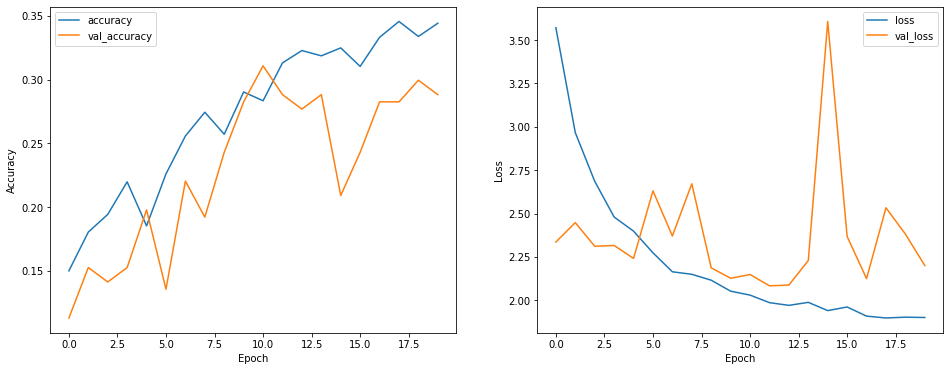

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

ax[0].plot(model_fit.history['accuracy'], label='accuracy')
ax[0].plot(model_fit.history['val_accuracy'], label='val_accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].plot(model_fit.history['loss'], label='loss')
ax[1].plot(model_fit.history['val_loss'], label='val_loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()

Evaluate test set

In [ ]:
test_set = test_datagen.flow_from_directory('test',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 190 images belonging to 10 classes.


In [ ]:
model.evaluate(test_set)

6/6 [==============================] - 35s 7s/step - loss: 2.1204 - accuracy: 0.3158


[2.120396852493286, 0.31578946113586426]

# Model 9




*   Add dropout(0.5)
*   Data augmentation (shear, zoom, horizontal,...)
*   Increase epochs from 10 to 100
*   Add callback
*   Add layer










Data preprocessing

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode='nearest'
                                   )

val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
training_set = train_datagen.flow_from_directory('train',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 1447 images belonging to 10 classes.


In [ ]:
validation_set = val_datagen.flow_from_directory('val',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 177 images belonging to 10 classes.


In [ ]:
training_set.class_indices

{'American_Staffordshire_terrier': 0,
 'Chihuahua': 1,
 'Ibizan_hound': 2,
 'Saluki': 3,
 'Scottish_deerhound': 4,
 'basset': 5,
 'papillon': 6,
 'redbone': 7,
 'toy_terrier': 8,
 'whippet': 9}

CNN

In [ ]:
model = Sequential([
                    Conv2D(16, (3,3), activation='relu', input_shape=(150,150,3)),
                    BatchNormalization(),
                    MaxPool2D(2,2),
                    

                    Conv2D(32, (3,3), activation='relu'),
                    BatchNormalization(),
                    MaxPool2D(2,2),

                    Conv2D(32, (3,3), activation='relu'),
                    BatchNormalization(),
                    MaxPool2D(2,2),

                    Dropout(0.5),

                    Flatten(),
                    Dense(128, activation='relu'),
                    Dense(10, activation='softmax')


])

CNN architecture

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
batch_normalization_3 (Batch (None, 148, 148, 16)      64        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
batch_normalization_4 (Batch (None, 72, 72, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 34, 34, 32)       

Compile and fit CNN model

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [ ]:
from keras import callbacks 
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                        mode ="min", patience = 8,  
                                        restore_best_weights = True)

model_fit = model.fit(
    training_set,
    # steps_per_epoch=2,
    epochs=100,
    validation_data=validation_set,
    callbacks=[earlystopping]
)

Epoch 1/100
46/46 [==============================] - 14s 285ms/step - loss: 3.9013 - accuracy: 0.1498 - val_loss: 3.0933 - val_accuracy: 0.0847
Epoch 2/100
46/46 [==============================] - 13s 274ms/step - loss: 2.3511 - accuracy: 0.1789 - val_loss: 3.1871 - val_accuracy: 0.1073
Epoch 3/100
46/46 [==============================] - 12s 271ms/step - loss: 2.3163 - accuracy: 0.1731 - val_loss: 3.0285 - val_accuracy: 0.1299
Epoch 4/100
46/46 [==============================] - 13s 272ms/step - loss: 2.3488 - accuracy: 0.1606 - val_loss: 3.1635 - val_accuracy: 0.1808
Epoch 5/100
46/46 [==============================] - 13s 273ms/step - loss: 2.3001 - accuracy: 0.1657 - val_loss: 2.5501 - val_accuracy: 0.2034
Epoch 6/100
46/46 [==============================] - 13s 272ms/step - loss: 2.2981 - accuracy: 0.1828 - val_loss: 2.6167 - val_accuracy: 0.1073
Epoch 7/100
46/46 [==============================] - 13s 274ms/step - loss: 2.2504 - accuracy: 0.2222 - val_loss: 2.3337 - val_accuracy:

Accuracy vs Epochs

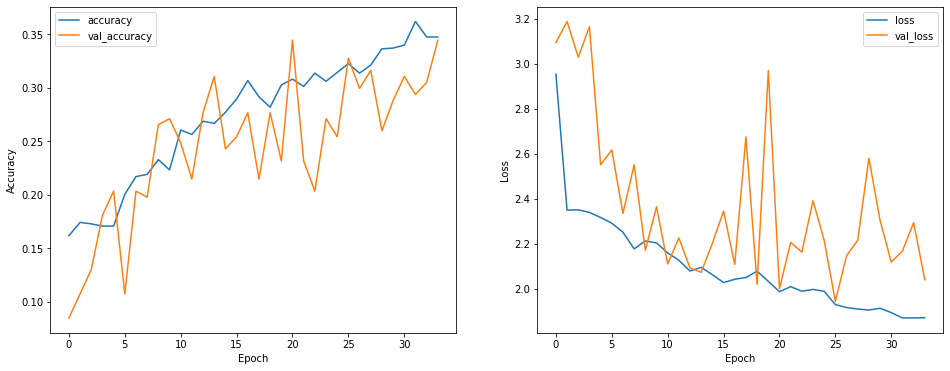

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

ax[0].plot(model_fit.history['accuracy'], label='accuracy')
ax[0].plot(model_fit.history['val_accuracy'], label='val_accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].plot(model_fit.history['loss'], label='loss')
ax[1].plot(model_fit.history['val_loss'], label='val_loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()

Evaluate test set

In [ ]:
test_set = test_datagen.flow_from_directory('test',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 190 images belonging to 10 classes.


In [ ]:
model.evaluate(test_set)

6/6 [==============================] - 1s 132ms/step - loss: 1.9791 - accuracy: 0.2579


[1.9791401624679565, 0.25789472460746765]

# Model 10




*   Add dropout(0.5)
*   Data augmentation (shear, zoom, horizontal,...)
*   Increase epochs from 10 to 100
*   Add callback
*   Add 2 layers










Data preprocessing

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode='nearest'
                                   )

val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
training_set = train_datagen.flow_from_directory('train',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 1447 images belonging to 10 classes.


In [ ]:
validation_set = val_datagen.flow_from_directory('val',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 177 images belonging to 10 classes.


In [ ]:
training_set.class_indices

{'American_Staffordshire_terrier': 0,
 'Chihuahua': 1,
 'Ibizan_hound': 2,
 'Saluki': 3,
 'Scottish_deerhound': 4,
 'basset': 5,
 'papillon': 6,
 'redbone': 7,
 'toy_terrier': 8,
 'whippet': 9}

CNN

In [ ]:
model = Sequential([
                    Conv2D(16, (3,3), activation='relu', input_shape=(150,150,3)),
                    MaxPool2D(2,2),

                    Conv2D(32, (3,3), activation='relu'),
                    MaxPool2D(2,2),

                    Conv2D(32, (3,3), activation='relu'),
                    MaxPool2D(2,2),

                    Conv2D(32, (3,3), activation='relu'),
                    MaxPool2D(2,2),

                    Dropout(0.5),

                    Flatten(),
                    Dense(128, activation='relu'),
                    Dense(10, activation='softmax')


])

CNN architecture

In [ ]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 34, 34, 32)        9248      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 17, 17, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 15, 15, 32)       

Compile and fit CNN model

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [ ]:
from keras import callbacks 
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                        mode ="min", patience = 8,  
                                        restore_best_weights = True)

model_fit = model.fit(
    training_set,
    # steps_per_epoch=3,
    epochs=100,
    validation_data=validation_set,
    callbacks=[earlystopping]
)

Epoch 1/100
46/46 [==============================] - 14s 281ms/step - loss: 2.3155 - accuracy: 0.1121 - val_loss: 2.2955 - val_accuracy: 0.1469
Epoch 2/100
46/46 [==============================] - 13s 272ms/step - loss: 2.2981 - accuracy: 0.1182 - val_loss: 2.2536 - val_accuracy: 0.2034
Epoch 3/100
46/46 [==============================] - 13s 277ms/step - loss: 2.2519 - accuracy: 0.1719 - val_loss: 2.1603 - val_accuracy: 0.2655
Epoch 4/100
46/46 [==============================] - 13s 273ms/step - loss: 2.2205 - accuracy: 0.1977 - val_loss: 2.1227 - val_accuracy: 0.2429
Epoch 5/100
46/46 [==============================] - 13s 272ms/step - loss: 2.1878 - accuracy: 0.2029 - val_loss: 2.1032 - val_accuracy: 0.2599
Epoch 6/100
46/46 [==============================] - 13s 275ms/step - loss: 2.1415 - accuracy: 0.2414 - val_loss: 2.0346 - val_accuracy: 0.2599
Epoch 7/100
46/46 [==============================] - 13s 272ms/step - loss: 2.1092 - accuracy: 0.2492 - val_loss: 2.0613 - val_accuracy:

Accuracy vs Epochs

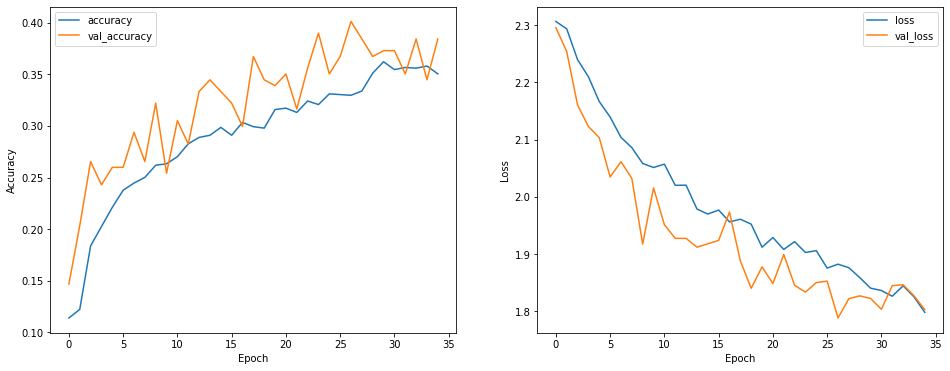

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

ax[0].plot(model_fit.history['accuracy'], label='accuracy')
ax[0].plot(model_fit.history['val_accuracy'], label='val_accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].plot(model_fit.history['loss'], label='loss')
ax[1].plot(model_fit.history['val_loss'], label='val_loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()

Evaluate test set

In [ ]:
test_set = test_datagen.flow_from_directory('test',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 190 images belonging to 10 classes.


In [ ]:
model.evaluate(test_set)

6/6 [==============================] - 1s 134ms/step - loss: 1.8550 - accuracy: 0.3579


[1.8550339937210083, 0.35789474844932556]